# SOCAT KPI Plots
This notebook allows you to generate various plots from the SOCAT data for KPI information.

- Begin by running the `Setup and connect to database` cell.
- Select the region of your choice. You will see a map of the region.
- Scroll through the remaining cells to generate plots.

**Prerequisites**
The notebooks `import_socat` and `import_regions` must be run before this notebook.

## Setup and connect to database

In [41]:
import sqlite3
from ipywidgets import interact, interactive, interactive_output, fixed, HBox, VBox, Label
import ipywidgets as widgets
from shapely import wkb
import geopandas as gpd
from matplotlib import pyplot as plt
import matplotlib
from datetime import datetime
import numpy as np
import pandas as pd
from osgeo import ogr
from shapely import wkt
import seaborn as sns

# Connect to database
DB_FILE = 'socat_kpi.sqlite'
conn = sqlite3.connect(DB_FILE)
conn.enable_load_extension(True)
conn.load_extension("mod_spatialite")

# Extract min/max year of SOCAT data
cur = conn.cursor()
cur.execute('SELECT MIN(year) FROM socat')
min_year = cur.fetchone()[0]

#cur = conn.cursor()
#cur.execute('SELECT MAX(year) FROM socat')
#max_year = cur.fetchone()[0]
max_year = 2024


# Select Region
Select the region that you're interested in exploring.

In [42]:
def load_shape(file):
    return gpd.read_file(file)

def load_region(region_id, mask):

    # Get the shape from the database
    cur.execute(f'SELECT AsBinary(shape) FROM shapes WHERE id = {region.value}')
    geom = wkb.loads(cur.fetchone()[0], hex=False)
    region_shape = gpd.GeoDataFrame([{'id': region.value, 'geometry': geom}], geometry='geometry', crs='EPSG:4326')

    # Apply the mask if necessary
    if mask == 0:
        masked_shape = region_shape
    elif mask == 1:
        mask = load_shape('shapes/masks/marcat_plus_gshhs.shp')
        masked_shape = region_shape.geometry.difference(mask)
    elif mask == 2:
        mask = load_shape('shapes/masks/marcat_continental_shelf.shp')
        masked_shape = gpd.overlay(region_shape, mask, how='intersection')
        
    coastlines = gpd.read_file('shapes/coastline/GSHHS_i_L1.shp')

    # Map display bounds
    minx, miny, maxx, maxy = region_shape.total_bounds
    padding_x = (maxx - minx) * 0.2  # 20% padding
    padding_y = (maxy - miny) * 0.2
    
    xlim = (minx - padding_x, maxx + padding_x)
    ylim = (miny - padding_y, maxy + padding_y)

    # Display the map
    fig, ax = plt.subplots(figsize=(12, 6))
    coastlines.plot(ax=ax, color='lightgray', linewidth=0.5)
    masked_shape.plot(ax=ax, color='lightblue', alpha=0.4, edgecolor='black')
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    plt.title(region.label)
    plt.show()

    return sqlite3.Binary(masked_shape.geometry.iloc[0].wkb)

# Region menu
menu_options = []

cur.execute("SELECT id, source, name FROM shapes ORDER BY source, name")
for record in cur:
    menu_options.append((f'{record[1]}: {record[2]}', record[0]))

region = widgets.Dropdown(
    options=menu_options,
    description='Region:'
)

# Coastal mask options
mask_options = []
mask_options.append(('Full Region', 0))
mask_options.append(('Exclude Continental Shelf', 1))
mask_options.append(('Continental Shelf Only', 2))

mask = widgets.RadioButtons(
    options=mask_options,
    description='Mask:'
)

region_select = interactive(load_region, region_id=region, mask=mask);
display(region_select)


interactive(children=(Dropdown(description='Region:', options=(('CCAMLR: Division 58.4.1', 19), ('CCAMLR: Divi…

# Make Plots
Each section below will generate plots for a given metric. Some come with options you can adjust.

## Observation Days Per Year
Shows the number of days with observations in each year.

This can be shown as an absolute value, or relative to the mean of a reference period.

Run the first cell to retrieve the data from the database. Use the second cell to plot it using the interactive controls.

In [44]:
print("Retrieving data...")

cur.execute(f"""WITH selected_region AS (
  SELECT shape AS region_shape,
         MbrMinX(shape) AS xmin,
         MbrMinY(shape) AS ymin,
         MbrMaxX(shape) AS xmax,
         MbrMaxY(shape) AS ymax
  FROM shapes
  WHERE id = {region.value}
)
SELECT 
  s.year,
  COUNT(DISTINCT s.month_day)
FROM 
  socat s,
  selected_region r
WHERE
  s.ROWID IN (
    SELECT pkid
    FROM idx_socat_position
    WHERE xmin <= r.xmax
      AND xmax >= r.xmin
      AND ymin <= r.ymax
      AND ymax >= r.ymin
  )
  AND ST_Intersects(s.position, ?)
GROUP BY 
  s.year
ORDER BY 
  s.year;
""", (region_select.result,))

years = []
counts = []

day_counts = dict()
for y in range(min_year, max_year + 1):
    day_counts[y] = 0

for record in cur.fetchall():
    day_counts[record[0]] = record[1]

print("Done")

Retrieving data...
Done


In [45]:
def days_per_year(use_reference, reference_start, reference_end, plot_min):

    reference_value = 0
    if use_reference:
        reference_value = np.mean([v for k, v in day_counts.items() if reference_start <= k <= reference_end])
    
    plot_counts = {key: value - reference_value for key, value in day_counts.items()}
    
    plt.bar(plot_counts.keys(), plot_counts.values())
    plt.xlabel('Year')
    
    if use_reference:
        plt.ylabel(f'Number of days relative to {reference_start}-{reference_end} mean')
    else:
        plt.ylabel('Number of Days')
    
    if not use_reference:
        plt.ylim((0, 366))
    else:
        plt.ylim((-365, 365))


    plt.xlim(plot_min - 1, max_year + 1)
    
    plt.title(f'{region.label} \n Days with observations in each year')
    plt.show()


plot_min = next((k for k, v in day_counts.items() if v > 0), None)

relative_checkbox = widgets.Checkbox(value=False, description='Relative to reference period', indent=False)
start_slider = widgets.IntSlider(min=1995, max=datetime.now().year - 1, step=1, value=2015)
end_slider = widgets.IntSlider(min=1995, max=datetime.now().year - 1, step=1, value=2019)

vbox1 = VBox([
    relative_checkbox,
    HBox([Label('Reference period start'), start_slider]),
    HBox([Label('Reference period end'), end_slider]),
])
display(vbox1)

w = interactive_output(days_per_year, {"use_reference": relative_checkbox, "reference_start": start_slider, "reference_end": end_slider, "plot_min": fixed(plot_min)})
display(w)

Output()

## Active platforms
Shows the number of platforms active in each year, grouped by country (based on the country code from the EXPO code).

### Caveats
- It is known that some platforms have been assigned incorrect country codes.
- There are instances where multiple platforms share the same platform code (e.g. US moorings). These are not separated.
- The country to which a platform is registered may be different to the country who is responsible for collecting the observations.

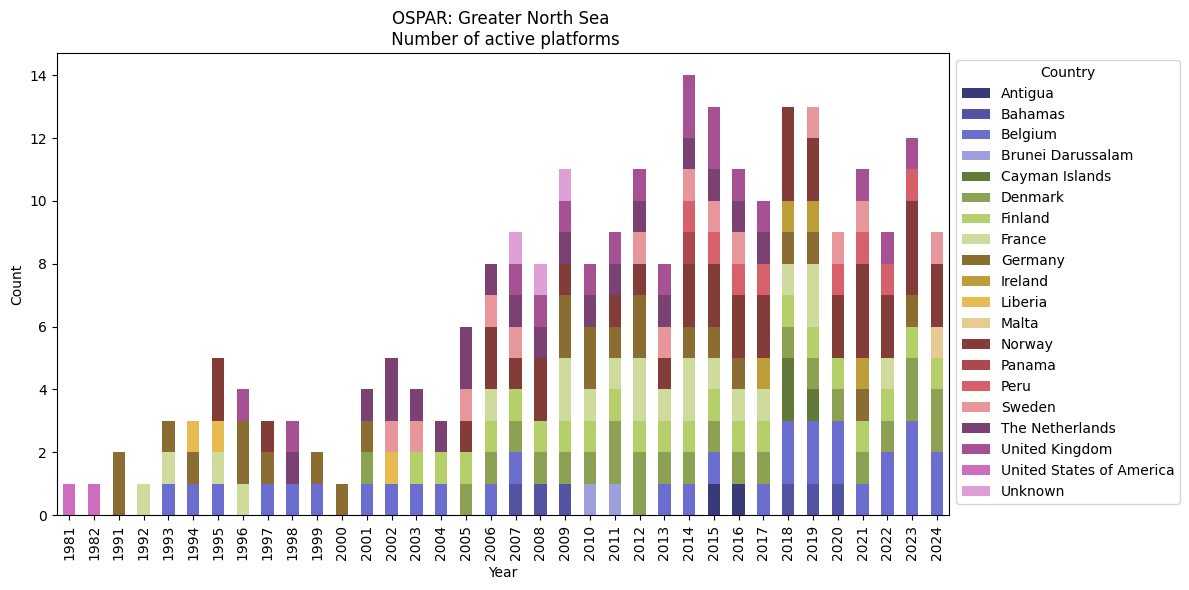

In [46]:
cur.execute(f"""WITH selected_region AS (
  SELECT shape AS region_shape,
         MbrMinX(shape) AS xmin,
         MbrMinY(shape) AS ymin,
         MbrMaxX(shape) AS xmax,
         MbrMaxY(shape) AS ymax
  FROM shapes
  WHERE id = {region.value}
)
SELECT 
  s.year,
  c.name,
  COUNT(DISTINCT s.platform_code)
FROM 
  socat s
  INNER JOIN countries c ON s.country = c.code,
  selected_region r
WHERE
  s.ROWID IN (
    SELECT pkid
    FROM idx_socat_position
    WHERE xmin <= r.xmax
      AND xmax >= r.xmin
      AND ymin <= r.ymax
      AND ymax >= r.ymin
  )
  AND ST_Intersects(s.position, ?)
GROUP BY 
  s.year, c.name
ORDER BY 
  s.year, c.name
""", (region_select.result, ))

rows = cur.fetchall()

df = pd.DataFrame(rows, columns=['year', 'country', 'count'])

pivot_df = df.pivot(index='year', columns='country', values='count').fillna(0)
num_countries = pivot_df.shape[1]
colors = matplotlib.colormaps['tab20b']

pivot_df.plot(kind='bar', stacked=True, figsize=(12, 6), color=[colors(i) for i in range(num_countries)])

plt.title(f'{region.label} \n Number of active platforms')
plt.xlabel('Year')
plt.ylabel('Count')
plt.legend(title='Country', bbox_to_anchor=(1, 1), loc='upper left')
plt.tight_layout()
plt.show()

## Observation Days Per Year By Country


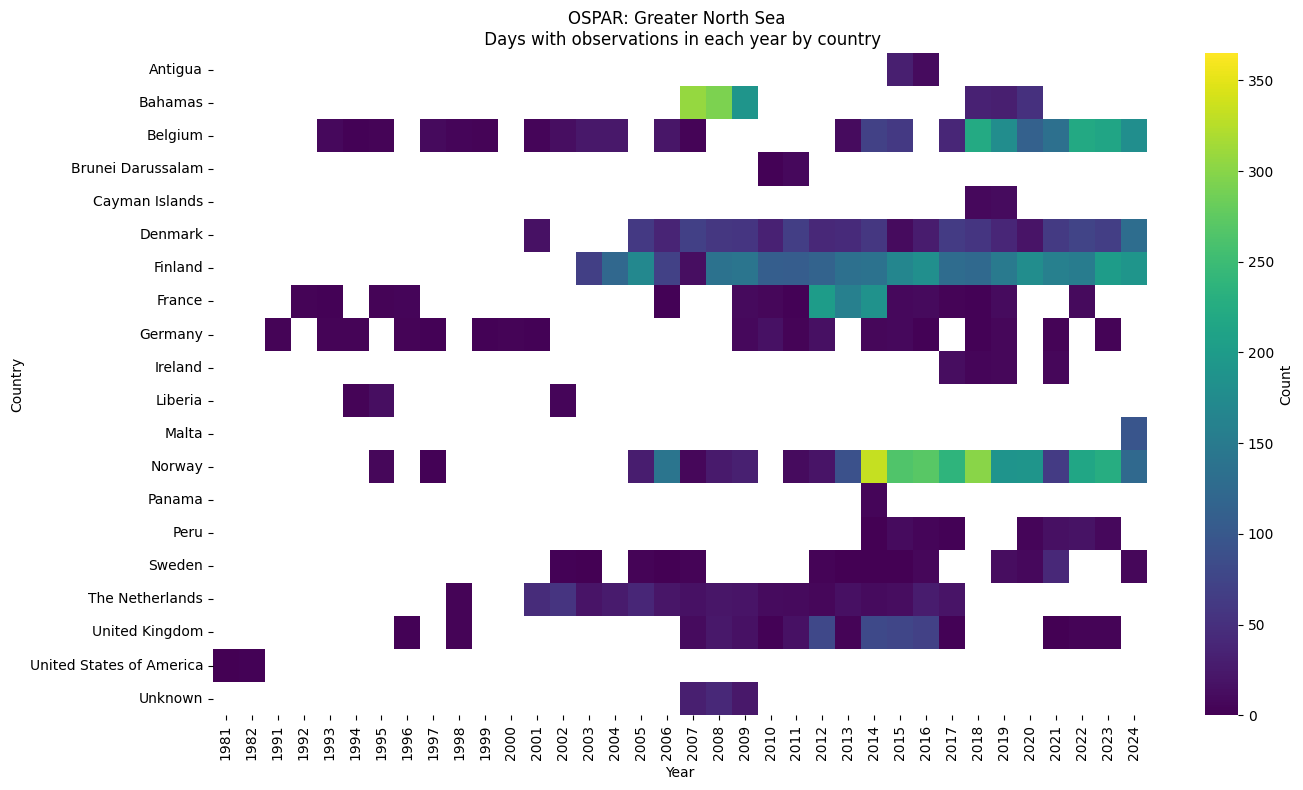

In [49]:
cur.execute(f"""WITH selected_region AS (
  SELECT shape AS region_shape,
         MbrMinX(shape) AS xmin,
         MbrMinY(shape) AS ymin,
         MbrMaxX(shape) AS xmax,
         MbrMaxY(shape) AS ymax
  FROM shapes
  WHERE id = {region.value}
)
SELECT 
  s.year,
  c.name,
  COUNT(DISTINCT s.month_day)
FROM 
  socat s
  INNER JOIN countries c ON s.country = c.code,
  selected_region r
WHERE
  s.ROWID IN (
    SELECT pkid
    FROM idx_socat_position
    WHERE xmin <= r.xmax
      AND xmax >= r.xmin
      AND ymin <= r.ymax
      AND ymax >= r.ymin
  )
  AND ST_Intersects(s.position, ?)
GROUP BY 
  s.year, c.name
ORDER BY 
  s.year, c.name;
""", (region_select.result,))

records = cur.fetchall()
df = pd.DataFrame(records, columns=['Year', 'Country', 'Days'])

# Pivot for heatmap
pivot_df = df.pivot(index='Country', columns='Year', values='Days')

# Plot heatmap
plt.figure(figsize=(14, 8))
sns.heatmap(pivot_df, annot=False, cmap='viridis', cbar_kws={'label': 'Count'}, vmin=0, vmax=365)

plt.title(f'{region.label} \n Days with observations in each year by country')
plt.xlabel('Year')
plt.ylabel('Country')
plt.tight_layout()
plt.show()

## Shutdown

In [9]:
cur.close()
conn.close()

# References

When presenting output from this notebook, the following citations are required:

## SOCAT
Bakker, Dorothee C. E.; Alin, Simone R.; Aramaki, Takafumi; Barbero, Leticia; Bates, Nicholas; Gkritzalis, Thanos; Jones, Steve D.; Kozyr, Alex; Lauvset, Siv K.; Macovei, Vlad A.; Metzl, Nicolas; Munro, David R.; Nakaoka, Shin-ichiro; O’Brien, Kevin M.; Olsen, Are; Pierrot, Denis; Steinhoff, Tobias; Sullivan, Kevin F.; Sutton, Adrienne J.; Sweeney, Colm; Wada, Chisato; Wanninkhof, Rik; Akl, John; Arbilla, Lisandro A.; Azetsu-Scott, Kumiko; Battisti, Roman; Beatty, Cory M.; Becker, Meike; Benoit-Cattin, Alice; Berghoff, Carla F.; Bittig, Henry C.; Bonin, Jennifer A.; Bott, Randy; Bozzano, Roberto; Burger, Eugene F.; Brunetti, Fabio; Cantoni, Carolina; Castelli, Giuliano; Chambers, Don P.; Chierici, Melissa; Corbo, Andrea; Cronin, Margot; Cross, Jessica N.; Currie, Kim I.; Dentico, Carlotta; Emerson, Steven R.; Enochs, Ian C.; Enright, Matt P.; Enyo, Kazutaka; Ericson, Ylva; Evans, Wiley; Fay, Amanda R.; Feely, Richard A.; Fragiacomo, Elena; Fransson, Agneta; Gehrung, Martina; Giani, Michele; Glockzin, Michael; Hamnca, Siyabulela; Holodkov, Nikola; Hoppema, Mario; Ibánhez, J. Severino P.; Kadono, Koji; Kamb, Linus; Kralj, Martina; Kristensin, Tor O.; Laudicella, V. Alessandro; Lefèvre, Nathalie; Leseurre, Coraline; Lo Monaco, Claire; Maenner Jones, Stacy; Maenza, Reinaldo A.; McAuliffe, Anna M.; Mdokwana, Baxolele; Monacci, Natalie M.; Musielewicz, Sylvia; Neill, Craig; Newberger, Tim; Nojiri, Yukihiro; Ohman, Mark D.; Ólafsdóttir, Sólveig R.; Olivier, Léa; Omar, Abdirahman M.; Osborne, John; Pensieri, Sara; Petersen, Wilhelm; Plueddemann, Albert J.; Rehder, Gregor; Roden, Nicholas P.; Rutgersson, Anna; Sallée, Jean-Baptiste; Sanders, Richard; Sarpe, Dick; Schirnik, Carsten; Schlitzer, Reiner; Send, Uwe; Skjelvan, Ingunn; Sutherland, Stewart, C.; T’Jampens, Michiel; Tamsitt, Veronica; Telszewski, Maciej; Theetaert, Hannelore; Tilbrook, Bronte; Trull, Tom; Tsanwani, Mutshutshu; Van de Velde, Sebastiaan; Van Heuven, Steven M. A. C.; Veccia, Martín H.; Voynova, Yoana G.; Weller, Robert A.; Williams, Nancy L. (2025). Surface Ocean CO2 Atlas Database Version 2025 (SOCATv2025) (NCEI Accession 0304549). NOAA National Centers for Environmental Information. Dataset. [https://doi.org/10.25921/648f-fv35](https://doi.org/10.25921/648f-fv35).

Bakker, D. C. E., Pfeil, B. Landa, C. S., Metzl, N., O’Brien, K. M., Olsen, A., Smith, K., Cosca, C., Harasawa, S., Jones, S. D., Nakaoka, S., Nojiri, Y., Schuster, U., Steinhoff, T., Sweeney, C., Takahashi, T., Tilbrook, B., Wada, C., Wanninkhof, R., Alin, S. R., Balestrini, C. F., Barbero, L., Bates, N. R., Bianchi, A. A., Bonou, F., Boutin, J., Bozec, Y., Burger, E. F., Cai, W.-J., Castle, R. D., Chen, L., Chierici, M., Currie, K., Evans, W., Featherstone, C., Feely, R. A., Fransson, A., Goyet, C., Greenwood, N., Gregor, L., Hankin, S., Hardman-Mountford, N. J., Harlay, J., Hauck, J., Hoppema, M., Humphreys, M. P., Hunt, C. W., Huss, B., Ibánhez, J. S. P., Johannessen, T., Keeling, R., Kitidis, V., Körtzinger, A., Kozyr, A., Krasakopoulou, E., Kuwata, A., Landschützer, P., Lauvset, S. K., Lefèvre, N., Lo Monaco, C., Manke, A., Mathis, J. T., Merlivat, L., Millero, F. J., Monteiro, P. M. S., Munro, D. R., Murata, A., Newberger, T., Omar, A. M., Ono, T., Paterson, K., Pearce, D., Pierrot, D., Robbins, L. L., Saito, S., Salisbury, J., Schlitzer, R., Schneider, B., Schweitzer, R., Sieger, R., Skjelvan, I., Sullivan, K. F., Sutherland, S. C., Sutton, A. J., Tadokoro, K., Telszewski, M., Tuma, M., Van Heuven, S. M. A. C., Vandemark, D., Ward, B., Watson, A. J., Xu, S. (2016) A multi-decade record of high quality fCO2 data in version 3 of the Surface Ocean CO2 Atlas (SOCAT). Earth System Science Data 8: 383-413. [doi:10.5194/essd-8-383-2016](https://doi.org/10.5194/essd-8-383-2016).

## Regions


## Coastal and Marginal Seas Mask
Laruelle, G. G., Dürr, H. H., Lauerwald, R., Hartmann, J., Slomp, C. P., Goossens, N., and Regnier, P. A. G. (2013) Global multi-scale segmentation of continental and coastal waters from the watersheds to the continental margins, Hydrol. Earth Syst. Sci., 17, 2029–2051, [doi:10.5194/hess-17-2029-2013](https://doi.org/10.5194/hess-17-2029-2013).

## This notebook
???